In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

import matplotlib.pyplot as plt
import seaborn as sns

import requests
import xmltodict
import json

from datetime import datetime

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) # FutureWarning 제거
warnings.filterwarnings(action='ignore')

In [2]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./data/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [3]:
csv_to_parquet('./data/train.csv', 'train')
csv_to_parquet('./data/test.csv', 'test')

train Done.
test Done.


### 데이터 불러오기

In [4]:
train = pd.read_parquet('./data/train.parquet')
test = pd.read_parquet('./data/test.parquet')

In [2]:
# train = pd.read_csv('./data/train.csv')
# test = pd.read_csv('./data/test.csv')

In [5]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


In [6]:
train.isnull().sum()

id                       0
base_date                0
day_of_week              0
base_hour                0
lane_count               0
road_rating              0
road_name                0
multi_linked             0
connect_code             0
maximum_speed_limit      0
vehicle_restricted       0
weight_restricted        0
height_restricted        0
road_type                0
start_node_name          0
start_latitude           0
start_longitude          0
start_turn_restricted    0
end_node_name            0
end_latitude             0
end_longitude            0
end_turn_restricted      0
target                   0
dtype: int64

In [46]:
# 한 가지 값만 존재하는 컬럼 
one_value = []
for i in train.columns:
    if len(train[i].value_counts()) <2:
        one_value.append(i)
one_value

['vehicle_restricted', 'height_restricted']

In [5]:
# 해당 컬럼 삭제
train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)
test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

In [33]:
from sklearn.preprocessing import LabelEncoder

items =  ['day_of_week', 'road_name', 'start_node_name', 'start_turn_restricted', 'end_node_name', 'end_turn_restricted']
train_label = train.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(train_label[i])
    train_label[i] = encoder.transform(train_label[i])

train_label = train_label.drop("id", axis=1)

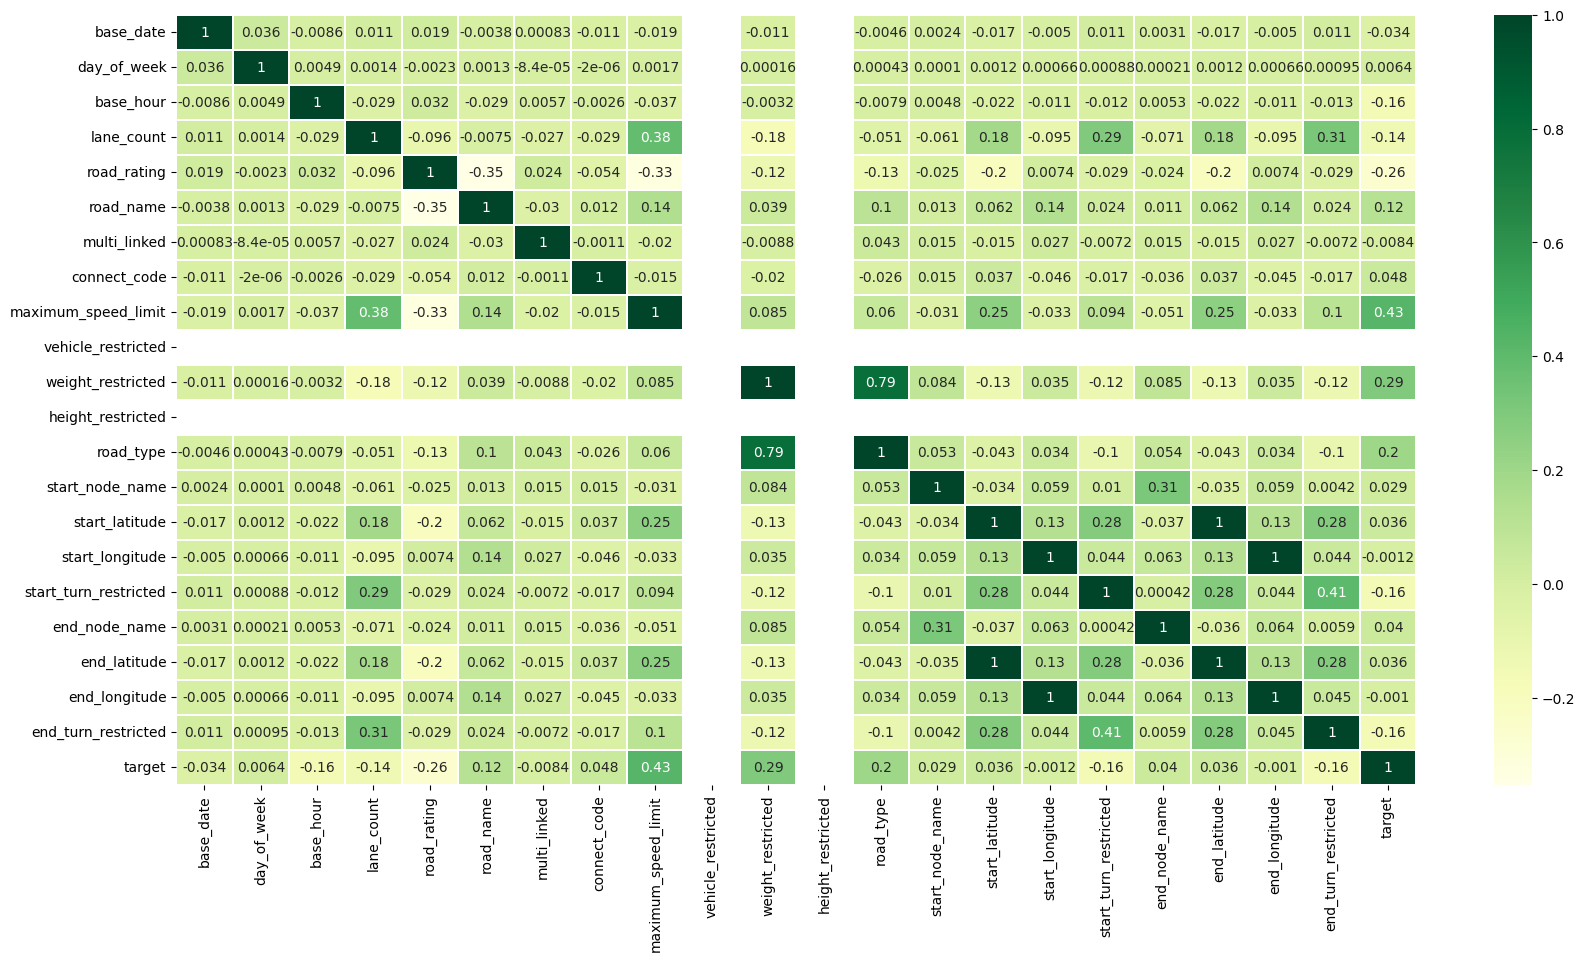

In [9]:
plt.figure(figsize=(20,10))
sns.heatmap(train_label.corr(), linewidths = 0.1, vmax = 1.0, cmap = 'YlGn', linecolor = "white",annot=True)
plt.show()

아래 컬럼과 상관관계를 가진다.
- maximum_speed_limit
- weight_restricted 
- road_type 
<br>상관관계 숫자 기준이 있어야 하나?

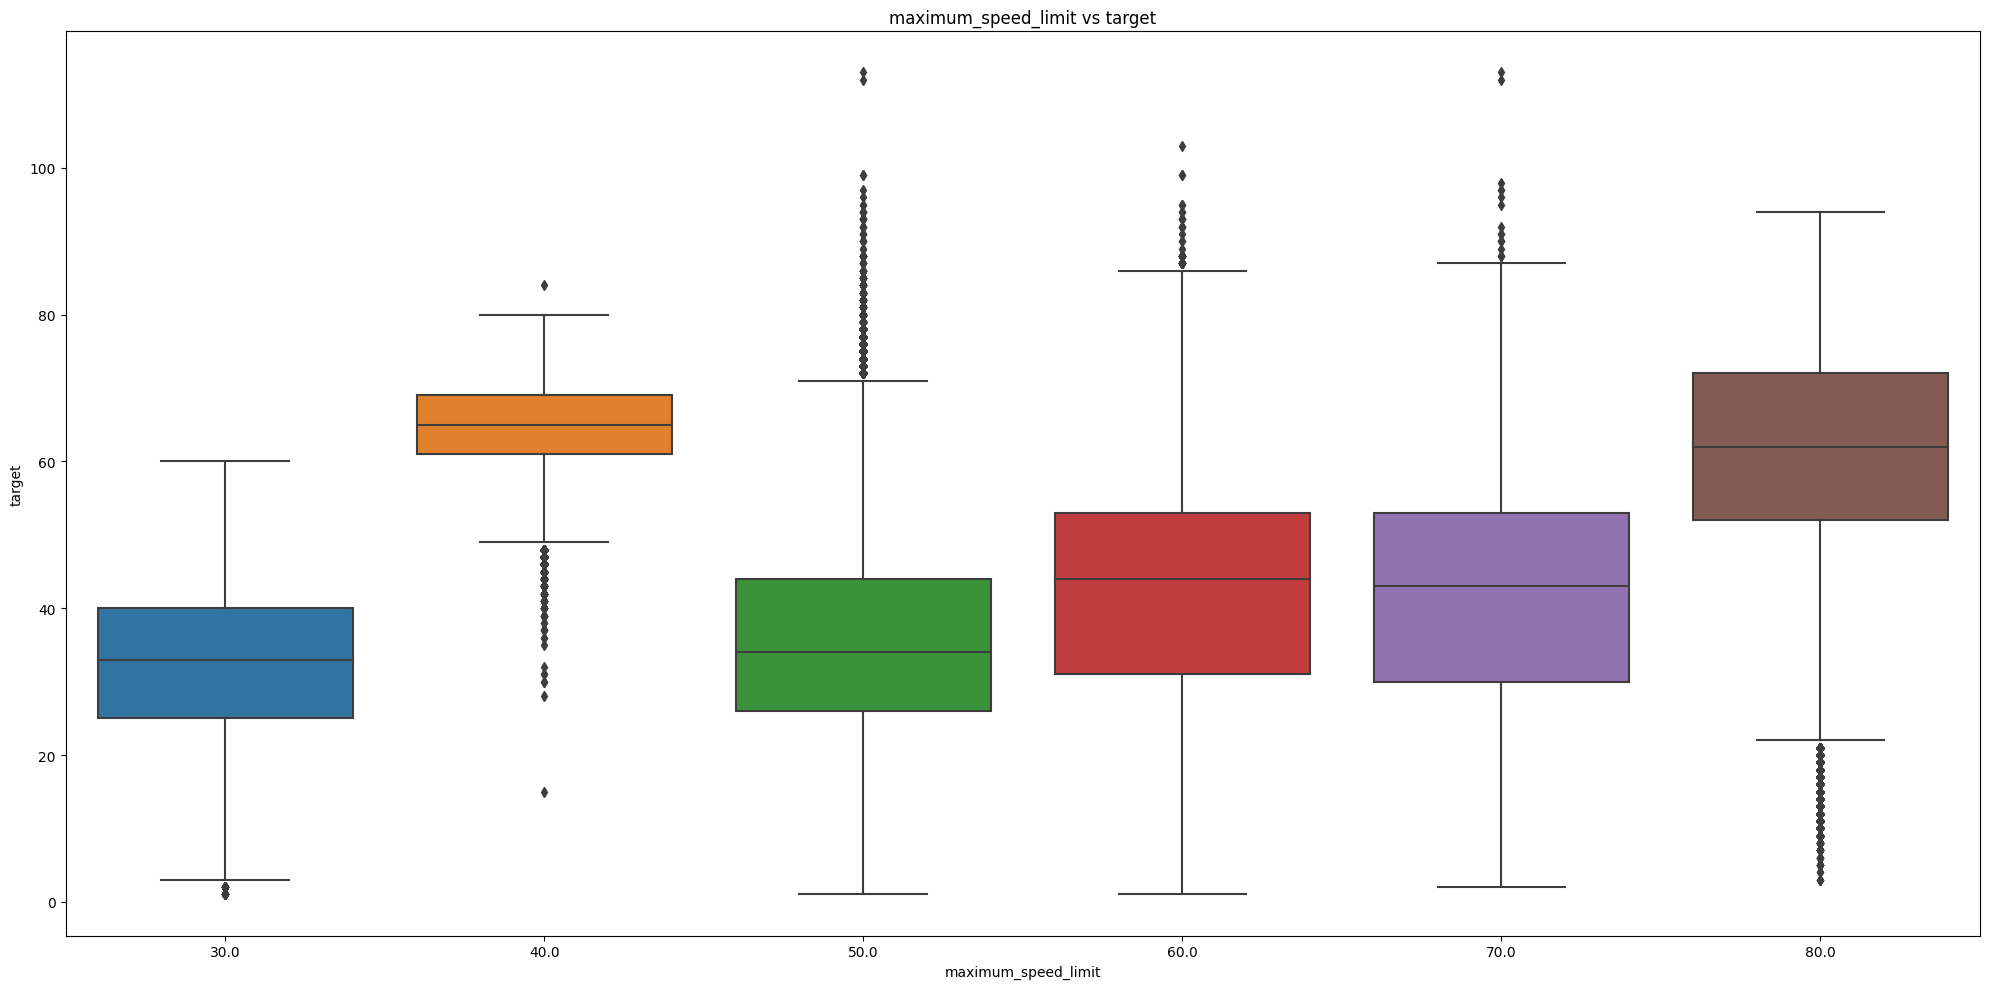

In [7]:
plt.figure(figsize=(20,10))
sns.boxplot(x='maximum_speed_limit',y='target',data=train).set(title='maximum_speed_limit vs target')
plt.tight_layout()
plt.show()


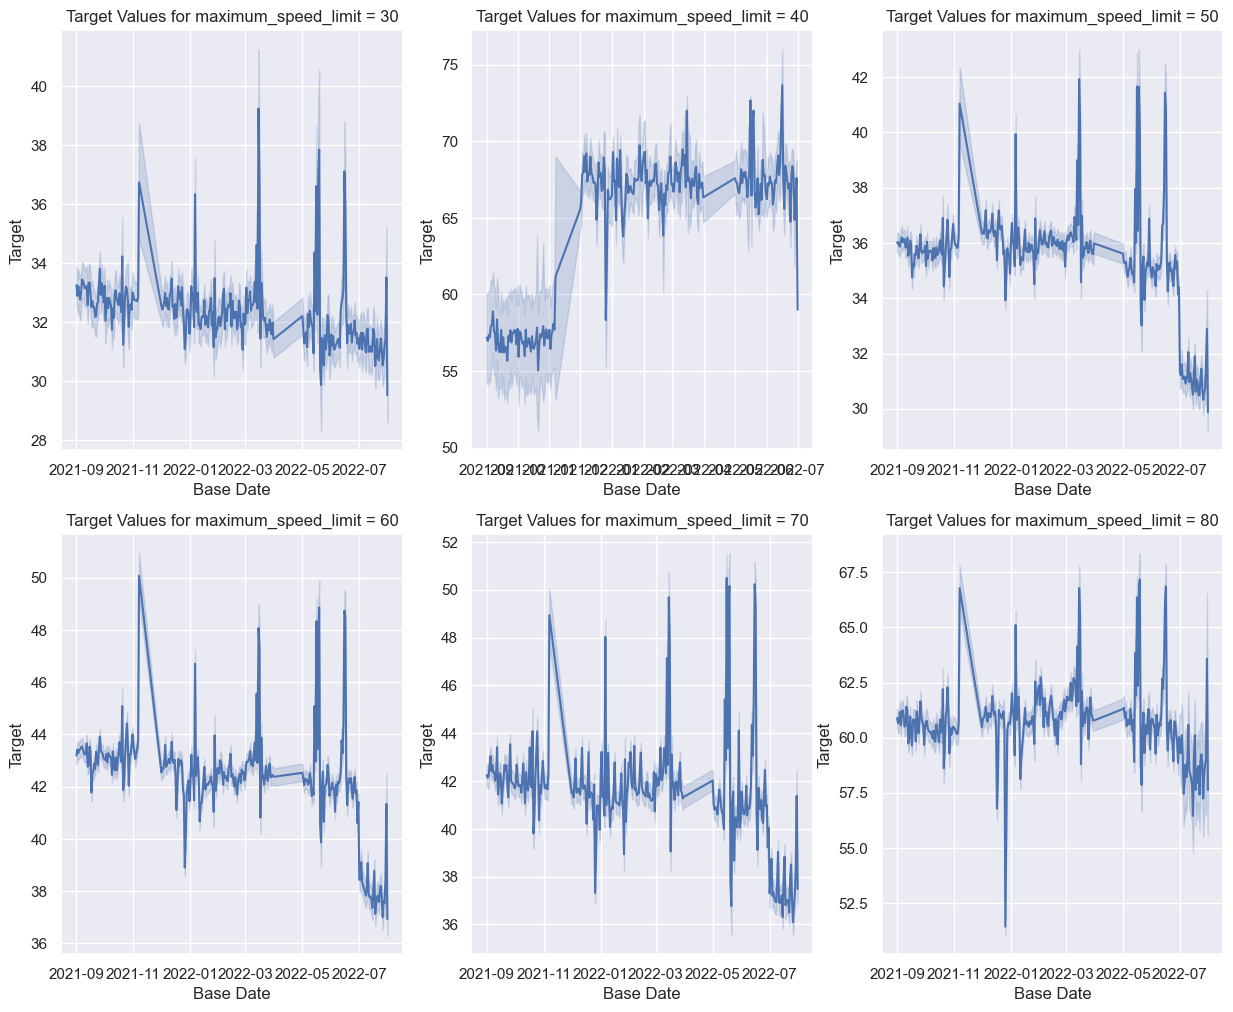

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

<Figure size 1000x600 with 0 Axes>

In [29]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
row = 0
col = 0
for i in range(6):
    speed = 30 + (i*10)
    filtered_df = train[train['maximum_speed_limit'] == speed]
    filtered_df["datetime"] = pd.to_datetime(filtered_df["base_date"],format='%Y%m%d')
    # 시각화 설정
    sns.set(style="darkgrid")
    plt.figure(figsize=(10, 6))

    # 시계열 그래프 플롯
    sns.lineplot(x='datetime', y='target', data=filtered_df, ax=axes[row, col])

    axes[row, col].set_title(f'Target Values for maximum_speed_limit = {speed}')
    axes[row, col].set_xlabel('Base Date')
    axes[row, col].set_ylabel('Target')

    # 다음 서브플롯 인덱스 계산
    col += 1
    if col == 3:
        row += 1
        col = 0

# 그래프 사이 간격 조정
plt.tight_layout()
plt.show()

In [33]:
train['maximum_speed_limit'].value_counts()

maximum_speed_limit
60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: count, dtype: int64

- 시속별로 교통량이 다른것을 확인할 수 있다.
- 특이사항은 40에서 target이 커짐. 데이터 작아서..?

[Text(0.5, 1.0, 'base_hour vs target')]

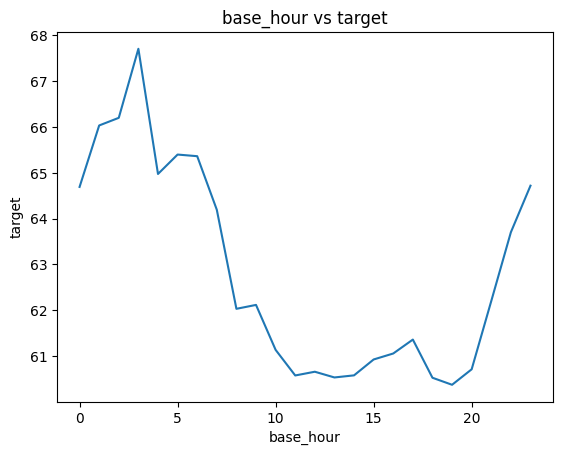

In [9]:
speed_limit_40  = train[train['maximum_speed_limit'] == 40]
speed_limit_40_time = speed_limit_40[['base_hour','target']]
speed_limit_40_time = speed_limit_40_time.groupby('base_hour').mean().reset_index()

sns.lineplot(x='base_hour',y='target',data=speed_limit_40_time).set(title='base_hour vs target')

제주도의 치한문제..? 어떤 도로길래

In [10]:
speed_limit_40['target'].max()
speed_limit_40_sorted = speed_limit_40.sort_values('target', ascending=False)[['road_name','start_node_name','end_node_name','target']]
# df_result = df_filtered['도로명'].reset_index(drop=True)
speed_limit_40_sorted.groupby(['road_name','start_node_name','end_node_name']).mean().reset_index()

,road_name,start_node_name,end_node_name,target
0,일반국도12호선,양계장,구엄교,66.903359
1,일반국도95호선,전표1교,동광1교차로,47.712526


시속이 40인 두 지역에서 평균 target이 높이 나타나는 경향이 있다.
- 과속 레벨 

### weight_restricted
- 통과 제한 하중이 높으면 무거운 차량이 적어지므로 속도 빨라질거다

In [11]:
train['weight_restricted'].value_counts()

weight_restricted
0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: count, dtype: int64

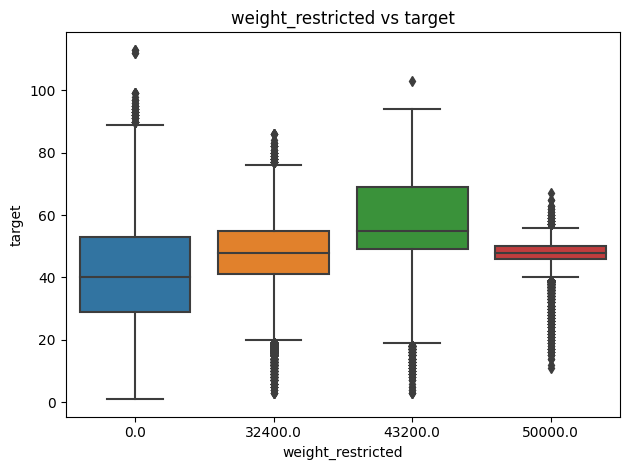

In [12]:
sns.boxplot(x='weight_restricted',y='target',data=train).set(title='weight_restricted vs target')
plt.tight_layout()
plt.show()

In [13]:
train.weight_restricted.value_counts()

weight_restricted
0.0        4032874
43200.0     410361
32400.0     239305
50000.0      18677
Name: count, dtype: int64

### road type

In [14]:
train['road_type'].value_counts()

road_type
0    3737117
3     964100
Name: count, dtype: int64

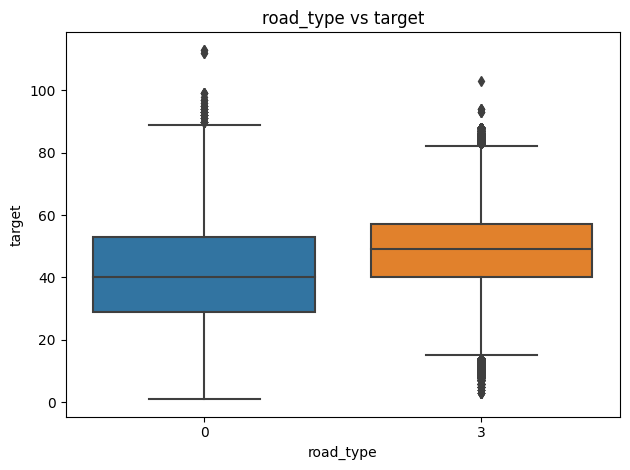

In [15]:
sns.boxplot(x='road_type',y='target',data=train).set(title='road_type vs target')

plt.tight_layout()
plt.show()

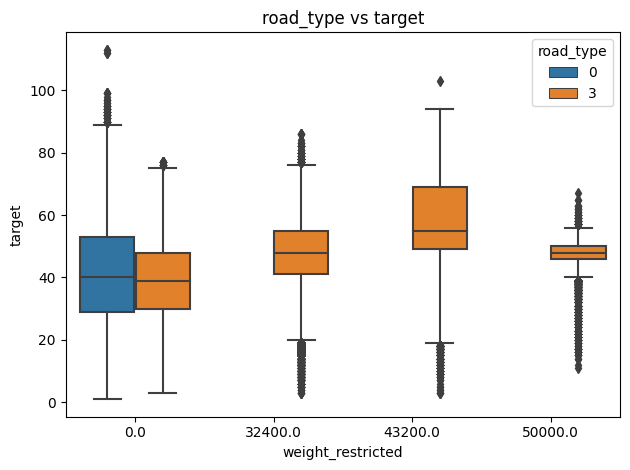

In [11]:
sns.boxplot(x='weight_restricted',y='target',data=train,hue='road_type').set(title='road_type vs target')

plt.tight_layout()
plt.show()

### lane count (차로수)

In [21]:
train['lane_count'].value_counts()

lane_count
2    2352092
1    1558531
3     790594
Name: count, dtype: int64

<Axes: xlabel='lane_count', ylabel='target'>

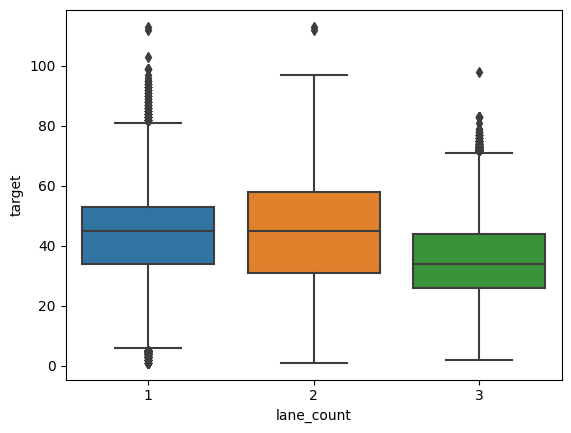

In [19]:
sns.boxplot(x = train["lane_count"], y = train["target"])

<Axes: xlabel='target', ylabel='Count'>

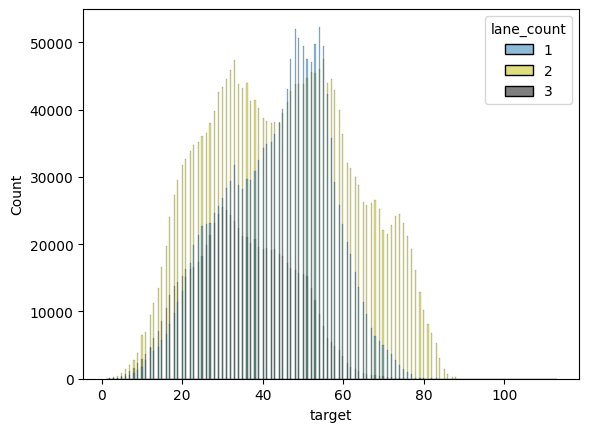

In [17]:
sns.histplot(x=train['target'], hue=train['lane_count'],palette=["C0", "y", "k"])

- 차선 증가하면 target 증가할 것이라 예상했지만, 오히려 감소

### road_rating (도로등급)
- 103: 일반국도
- 107: 시도 군도
- 106: 지방도

In [21]:
train.road_rating.value_counts()

road_rating
103    2159511
107    1582214
106     959492
Name: count, dtype: int64

<Axes: xlabel='road_rating', ylabel='target'>

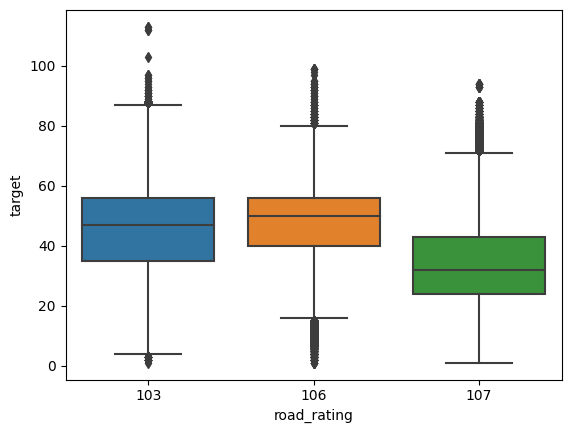

In [20]:
sns.boxplot(x = train["road_rating"], y = train["target"])

### multi_linked (중용구간)
- 중용구간: 2개 이상의 노선이 도로의 일정 구간을 공동으로 사용하는 구간

In [22]:
train["multi_linked"].value_counts()

multi_linked
0    4698978
1       2239
Name: count, dtype: int64

<Axes: xlabel='multi_linked', ylabel='target'>

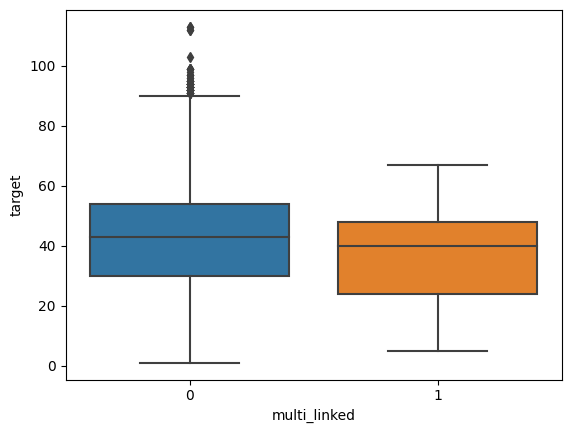

In [23]:
sns.boxplot(x = train["multi_linked"], y = train["target"])

In [10]:
train.groupby("multi_linked")["target"].mean()

multi_linked
0    42.791370
1    36.642698
Name: target, dtype: float64

<Axes: xlabel='road_type', ylabel='target'>

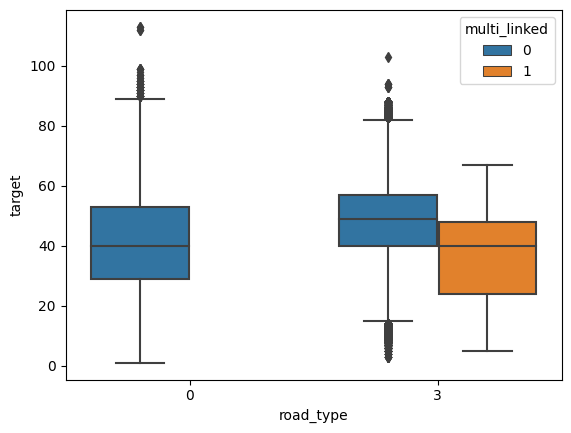

In [14]:
sns.boxplot(x = "road_type", y = "target",data=train,hue="multi_linked")

In [21]:
train[(train["multi_linked"] == 1) & (train["road_type"] == 0)] 

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day


- multi_linked가 1인 도로중 road_type이 0인 도로는 존재하지 않는다.
- multi_linked 컬럼 삭제해도 무방

In [6]:
train.drop(columns='multi_linked', axis=1, inplace=True)
test.drop(columns='multi_linked', axis=1, inplace=True)

### connect_code
- 연결로: 입체교차하는 도로에서 서로 교차하는 도로를 연결하거나 서로 높이 차이가 있는 도로를 연결해 주는 도로를 말한다.
- 103: 고속도로 연결로

In [23]:
train["connect_code"].value_counts()

connect_code
0      4689075
103      12142
Name: count, dtype: int64

<Axes: xlabel='connect_code', ylabel='target'>

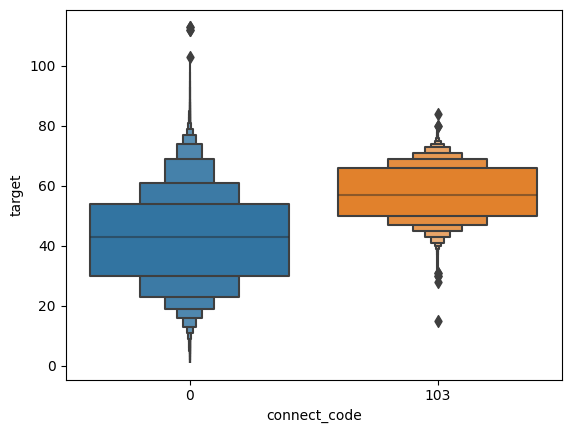

In [27]:
sns.boxenplot(x=train["connect_code"], y = train["target"])

road_type과 비교

### start_turn_restricted & end_turn_restricted

In [7]:
train["start_turn_restricted"].value_counts()
train["start_turn_restricted"] = train["start_turn_restricted"].replace({"없음":0,"있음":1})

In [10]:
train["start_turn_restricted"].value_counts()
train["end_turn_restricted"] = train["end_turn_restricted"].replace({"없음":0,"있음":1})

<Axes: xlabel='start_turn_restricted', ylabel='target'>

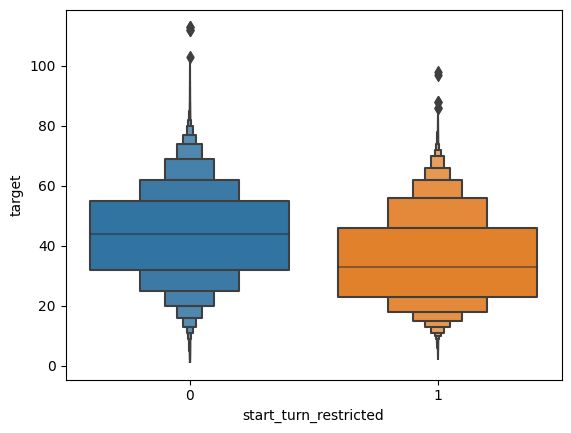

In [8]:
sns.boxenplot(x=train["start_turn_restricted"],y=train["target"])

<Axes: xlabel='end_turn_restricted', ylabel='target'>

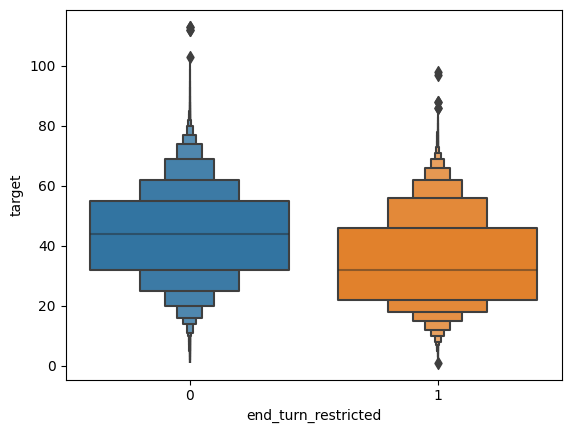

In [11]:
sns.boxenplot(x=train["end_turn_restricted"],y=train["target"])

![한국도로공사](%ED%95%9C%EA%B5%AD%EB%8F%84%EB%A1%9C%EA%B3%B5%EC%82%AC.png)

확인 해볼거
- 추이 그래프 (날짜별, 시간대별, 요일별)
- 공휴일
- 눈, 기온, 비 순으로 교통량과 관계가 밀접
- 전체 지도별 도로 표시
- 컬럼이 너무 많아서 각 컬럼별 상관계수

### 년도/월/일별 추이 그래프

In [14]:
train["datetime"] = pd.to_datetime(train["base_date"],format='%Y%m%d')

In [15]:
train['base_date'].min()

20210901

In [16]:
train['base_date'].max()

20220731

In [17]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day'] = train['datetime'].dt.day

In [77]:
train_date = train[['datetime','target']]
train_date = train_date.groupby('datetime').mean().reset_index()

train_time = train[['base_hour','target']]
train_time = train_time.groupby('base_hour').mean().reset_index()

train_day = train[['day_of_week','target']]
train_day = train_day.groupby('day_of_week').mean()
train_day = train_day.reindex(['월','화','수','목','금','토','일']).reset_index()

train_time.loc[train_time['target'].idxmin(), 'base_hour']
train_day.head(7)


,day_of_week,target
0,월,42.761365
1,화,42.699198
2,수,42.770372
3,목,42.768345
4,금,42.450328
5,토,42.894117
6,일,43.179300


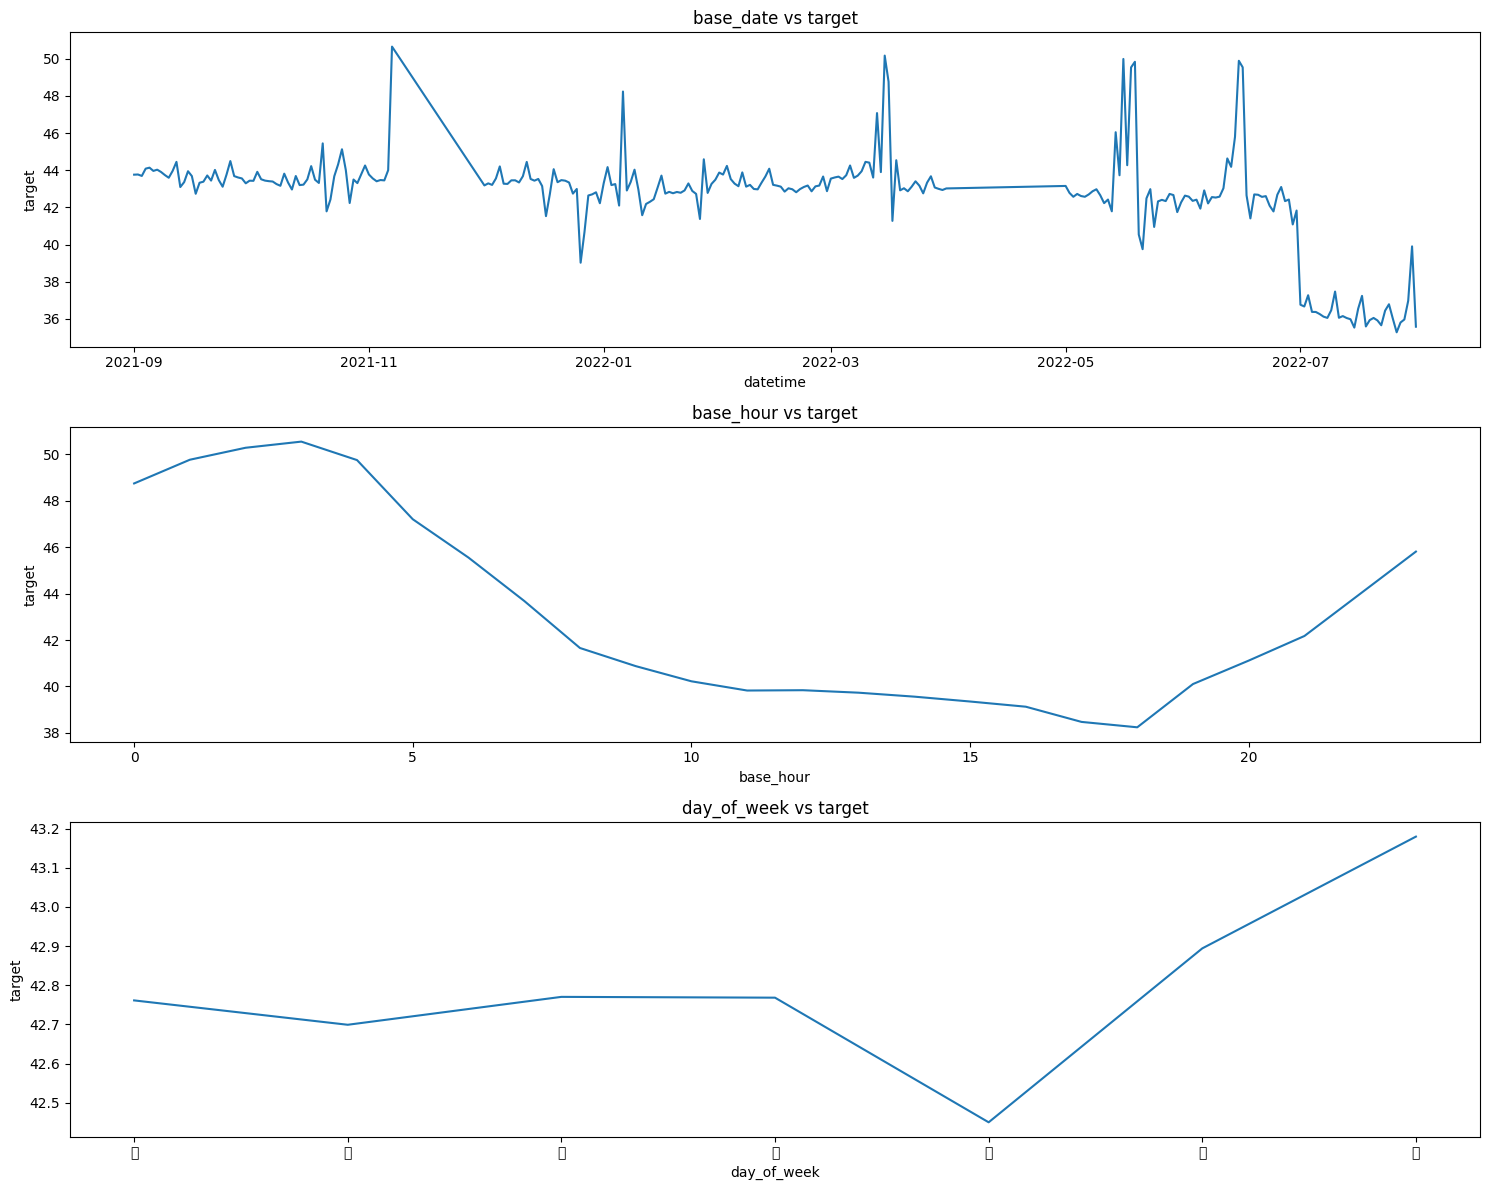

In [42]:
fig, axes = plt.subplots(3, figsize=(15,12))

sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[0]).set(title='base_date vs target')
sns.lineplot(x='base_hour',y='target',data=train_time,ax=axes[1]).set(title='base_hour vs target')
sns.lineplot(x='day_of_week',y='target',data=train_day,ax=axes[2]).set(title='day_of_week vs target')

plt.rcParams['font.family'] = 'STIXNonUnicode'
plt.tight_layout()
plt.show()

In [19]:
train[(train['year']==2021) & (train['month']==11) & (train['day'] > 7)]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day


In [20]:
train[(train['year']==2022) & (train['month']==4) & (train['day'] > 31)]

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,connect_code,maximum_speed_limit,weight_restricted,...,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day


- 21년 11월, 22년 4월 데이터 비어있음
- 데이터가 1년 주기도 돌지 못하기에 년도의 주기성으로 분석하기는 힘들것이라 판단

### 그렇다면 날짜별로 위치가 빈 데이터도 있을까?

- 7월 관광객 많아졌을것이다

In [37]:
tourist = pd.read_csv("./data/tourist.csv")
tourist.head(12)

,year,month,tourist
0,2021,9,872396
1,2021,10,1222094
2,2021,11,1204344
3,2021,12,1090607
4,2022,1,1170802
5,2022,2,1029503
6,2022,3,873086
7,2022,4,1178456
8,2022,5,1306537
9,2022,6,1283470


In [26]:
tourist

,datetime,target
0,2021-09-01,43.760268
1,2021-09-02,43.769578
2,2021-09-03,43.692354
3,2021-09-04,44.084787
4,2021-09-05,44.136858


<Axes: ylabel='tourist'>

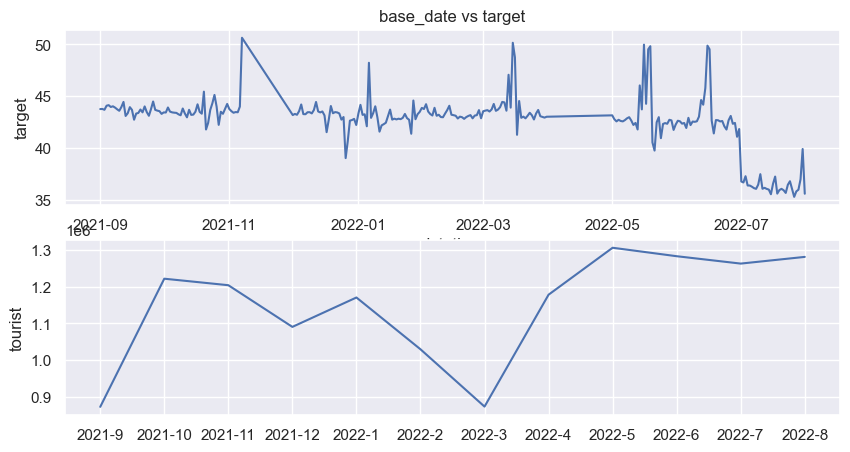

In [57]:
fig, axes = plt.subplots(2, figsize=(10,5))
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[0]).set(title='base_date vs target')
sns.lineplot(x=tourist['year'].astype(str) + '-' + tourist['month'].astype(str),y=tourist['tourist'],ax=axes[1])


In [34]:
train_date_mean.head(13)

,year,month,target
0,2021,9,43.691827
1,2021,10,43.534053
2,2021,11,44.614494
3,2021,12,43.023041
4,2022,1,43.159414
5,2022,2,43.261288
6,2022,3,43.935915
7,2022,5,43.245622
8,2022,6,43.123323
9,2022,7,36.369040


### 토/일 7월 빼고 
- 7월에 관광객이 많이 왔을것이기 때문에 

In [22]:
train_exc_7 = train[train['month'] != 7]
train_day_exc_7 = train_exc_7[['day_of_week','target']]
train_day_exc_7 = train_day_exc_7.groupby('day_of_week').mean()
train_day_exc_7 = train_day_exc_7.reindex(['월','화','수','목','금','토','일']).reset_index()
train_day_exc_7

,day_of_week,target
0,월,43.164899
1,화,43.098667
2,수,43.170332
3,목,43.140092
4,금,42.879420
5,토,43.290647
6,일,43.606582


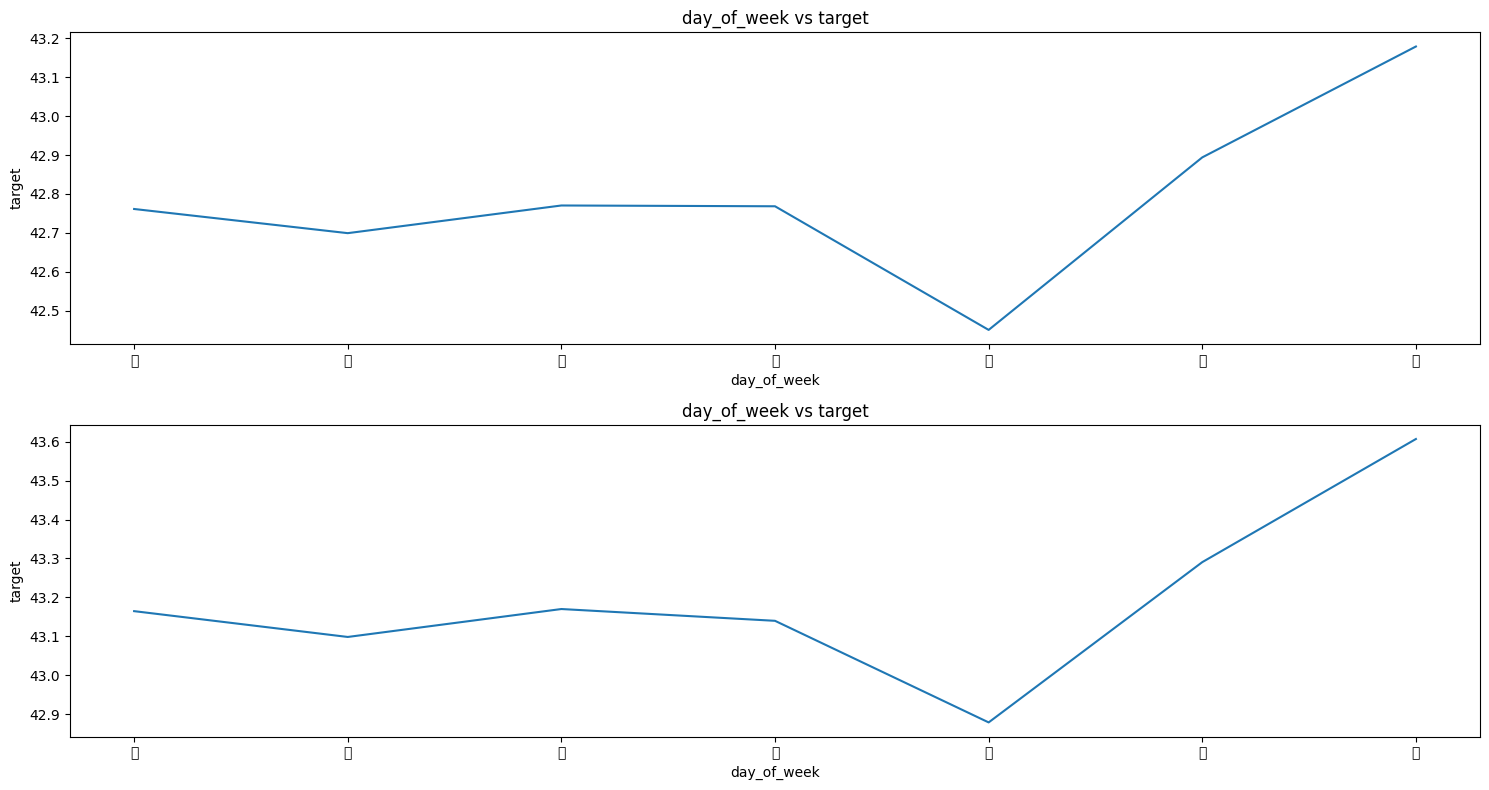

In [23]:
fig, axes = plt.subplots(2, figsize=(15,8))

sns.lineplot(x='day_of_week',y='target',data=train_day,ax=axes[0]).set(title='day_of_week vs target')
sns.lineplot(x='day_of_week',y='target',data=train_day_exc_7,ax=axes[1]).set(title='day_of_week vs target')

plt.rcParams['font.family'] = 'STIXNonUnicode'
plt.tight_layout()
plt.show()

- 7월과 주말의 연관성은 없어보인다.

- 관광객, 시민 들의 교통량 비교


-  월별 요일

### 공휴일 시각화

공휴일 데이터 불러오기

In [14]:
def get_holiday_data(year):
    url = 'http://apis.data.go.kr/B090041/openapi/service/SpcdeInfoService/getRestDeInfo'
    params = {
        'serviceKey': 'lUyD7/c6oiXRywzql7NJsMdnhrTjYOH+Rx/4siN3lV2/J2bWu4UfjpTnBTl150QccIo/8rglYGnTQW2XaKH81g==',
        'solYear': str(year),
        'numOfRows': '100' 
    }

    response = requests.get(url, params=params)
    xml_data = response.content
    json_data = json.dumps(xmltodict.parse(xml_data), indent=4)

    data = json.loads(json_data)

    items = data['response']['body']['items']['item']
    holiday_data = pd.DataFrame(items)

    return holiday_data

holiday_2021 = get_holiday_data(2021)
holiday_2022 = get_holiday_data(2022)

holiday_data = pd.concat([holiday_2021, holiday_2022],ignore_index=True)[['dateName','locdate']]
holiday_data["datetime"] = pd.to_datetime(holiday_data["locdate"],format='%Y%m%d')

holiday_data
# holiday_data.to_csv('./data/holiday.csv', index=False)

,dateName,locdate,datetime
0,1월1일,20210101,2021-01-01
1,설날,20210211,2021-02-11
2,설날,20210212,2021-02-12
3,설날,20210213,2021-02-13
4,삼일절,20210301,2021-03-01
5,어린이날,20210505,2021-05-05
6,부처님오신날,20210519,2021-05-19
7,현충일,20210606,2021-06-06
8,광복절,20210815,2021-08-15
9,대체공휴일,20210816,2021-08-16


In [15]:
# 공휴일이면 is_holiday에 'Y' 값 표시
train['is_holiday'] = train['datetime'].isin(holiday_data['datetime']).map({True: 'Y', False: 'N'})

- 데이터 확인 필요 없을수 있음

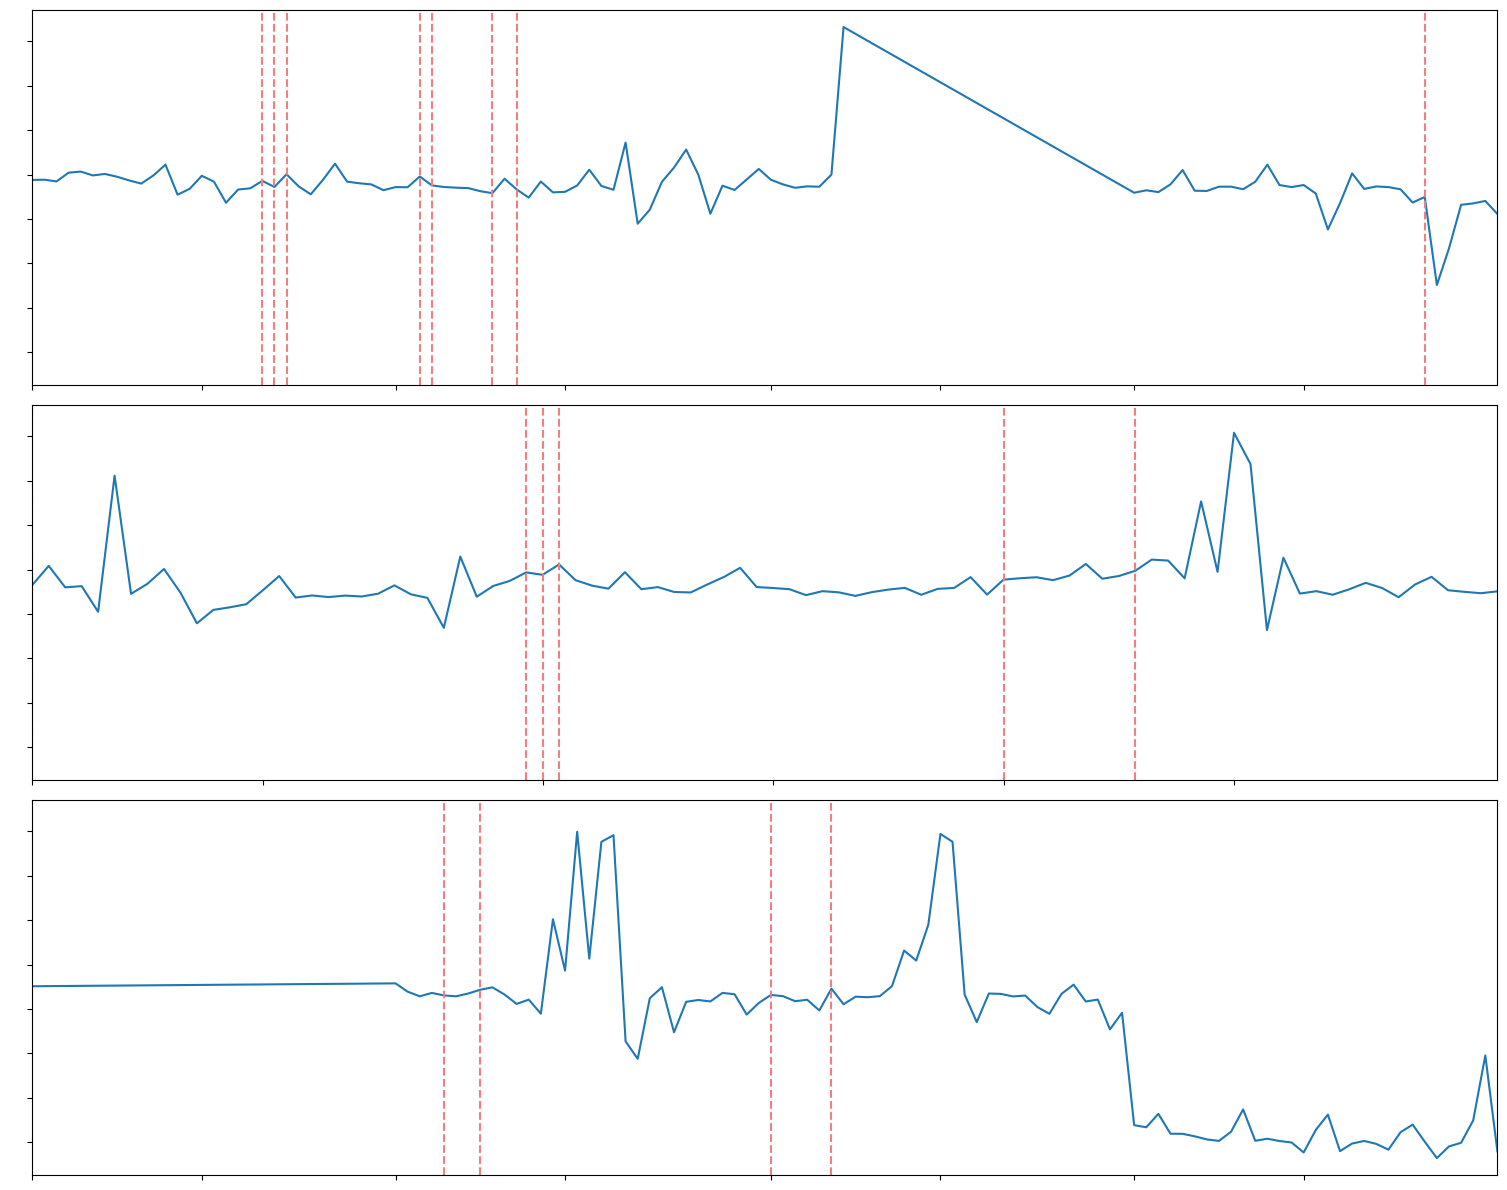

In [16]:
train_date = train[['datetime','target']]
train_date = train_date.groupby('datetime').mean().reset_index()
train_date['is_holiday'] = train_date['datetime'].isin(holiday_data['datetime']).map({True: 'Y', False: 'N'})

fig, axes = plt.subplots(3, figsize=(15,12))
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[0])
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[1])
sns.lineplot(x='datetime',y='target',data=train_date,ax=axes[2])

axes[0].set_xlim([datetime(2021, 9, 1), datetime(2021, 12, 31)])
axes[1].set_xlim([datetime(2022, 1, 1), datetime(2022, 3, 31)])
axes[2].set_xlim([datetime(2022, 4, 1), datetime(2022, 7, 31)])

for ax in axes:
    for _, row in train_date[train_date['is_holiday'] == 'Y'].iterrows():
        ax.axvline(x=row['datetime'], color='lightcoral', linestyle='--')

# plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### 기온 - 교통량 

In [17]:
# 제주도 기온, 강수 csv 파일 불러오기
def read_csv_jeju(filename):
    filename = pd.read_csv(f"./data/{filename}.csv", encoding='euc-kr')
    filename['날짜'] = filename['날짜'].str.replace('\t','')
    filename["날짜"] = pd.to_datetime(filename["날짜"],format='%Y-%m-%d')
    filename = filename.rename(columns={'날짜':'datetime'})
    return filename

In [36]:
temper = read_csv_jeju('temperature_jeju')[['datetime','평균기온(℃)']]
rain = read_csv_jeju('rain_jeju')[['datetime','강수량(mm)']]
rain.head()
# train = pd.merge(train, temper, on='datetime', how='left')
# train

,datetime,강수량(mm)
0,2021-09-01,14.5
1,2021-09-02,37.8
2,2021-09-03,21.8
3,2021-09-04,NaN
4,2021-09-05,7.6


- 스케일링
- 이동평균 추가
- 바 차트 만들기

In [37]:
merged_df = pd.merge(temper, rain, on='datetime', how='inner')
temp_rain = pd.merge(merged_df, train_date, left_on='datetime', right_on='datetime', how='inner')
temp_rain.head()

,datetime,평균기온(℃),강수량(mm),target,is_holiday
0,2021-09-01,28.4,14.5,43.760268,N
1,2021-09-02,25.0,37.8,43.769578,N
2,2021-09-03,24.2,21.8,43.692354,N
3,2021-09-04,25.3,NaN,44.084787,N
4,2021-09-05,24.5,7.6,44.136858,N


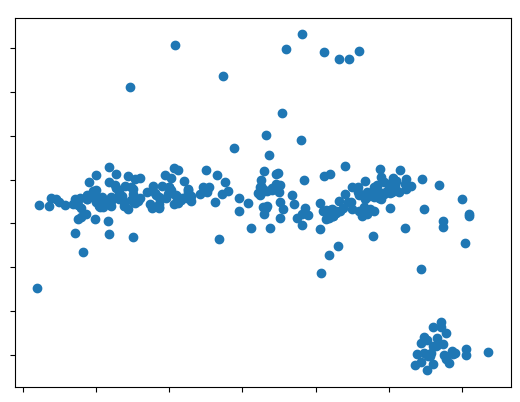

In [29]:
# 온도와 target의 관계 시각화
plt.scatter(temp_rain['평균기온(℃)'], temp_rain['target'])
plt.xlabel('평균기온(℃)')
plt.ylabel('target')
plt.title('온도와 target의 관계')
plt.show()


In [30]:
# 년/월별 강수량 총 합
rain['year'] = rain['datetime'].dt.year
rain['month'] = rain['datetime'].dt.month
rain = rain[['year','month','강수량(mm)']].groupby(['year','month']).sum('강수량(mm)').reset_index()
rain

,year,month,강수량(mm)
0,2021,9,493.1
1,2021,10,32.1
2,2021,11,63.8
3,2021,12,31.4
4,2022,1,33.6
5,2022,2,25.1
6,2022,3,96.1
7,2022,4,84.0
8,2022,5,9.1
9,2022,6,143.6


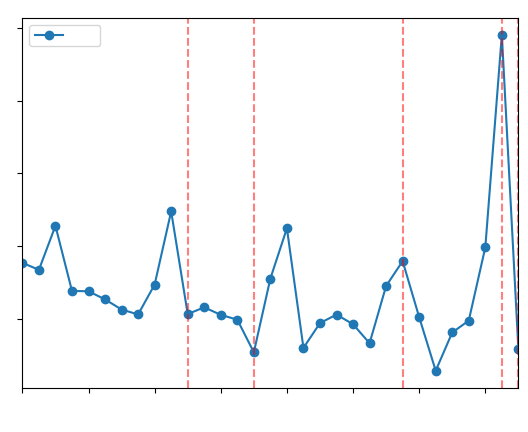

In [61]:
train_21_09 = train[(train['year'] == 2022) & (train['month'] == 7)]

train_date_21_09 = train_21_09[['datetime','target']]
train_date_21_09 = train_date_21_09.groupby('datetime').mean().reset_index()

plt.plot(train_date_21_09['datetime'], train_date_21_09['target'], marker='o', linestyle='-', label='target')
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Target Variation in September 2021')

# temp_rain 데이터프레임에서 강수량이 있는 날짜에 세로 선 그리기
for index, row in temp_rain.iterrows():
    if  (row['강수량(mm)'] >= 10):
        plt.axvline(x=row['datetime'], color='red', linestyle='--', alpha=0.5)
plt.xlim(train_date_21_09['datetime'].iloc[0], train_date_21_09['datetime'].iloc[-1])
plt.legend()
plt.xticks(rotation=45)
plt.show()

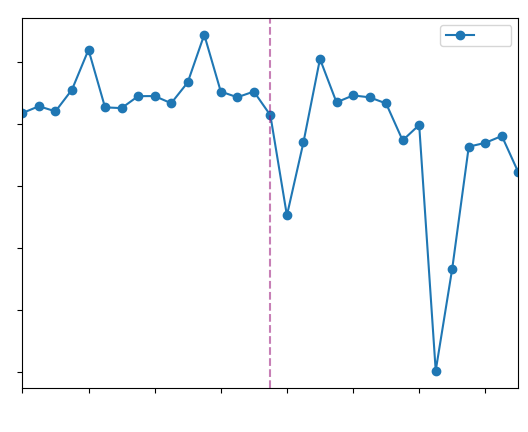

In [67]:
train_21_09 = train[(train['year'] == 2021) & (train['month'] == 12)]

train_date_21_09 = train_21_09[['datetime','target']]
train_date_21_09 = train_date_21_09.groupby('datetime').mean().reset_index()

plt.plot(train_date_21_09['datetime'], train_date_21_09['target'], marker='o', linestyle='-', label='target')
plt.xlabel('Date')
plt.ylabel('Target')
plt.title('Target Variation in September 2021')

for index, row in temp_rain.iterrows():
    if (row['강수량(mm)'] >= 10):
        alpha = min(row['강수량(mm)'] / 50, 1.0)  # 알파 값 계산
        color = (1.0 - alpha, 0.0, alpha)  # RGB 값 계산 (파란색에서 빨간색으로 변화)
        plt.axvline(x=row['datetime'], color=color, linestyle='--', alpha=0.5)
plt.xlim(train_date_21_09['datetime'].iloc[0], train_date_21_09['datetime'].iloc[-1])
plt.legend()
plt.xticks(rotation=45)
plt.show()

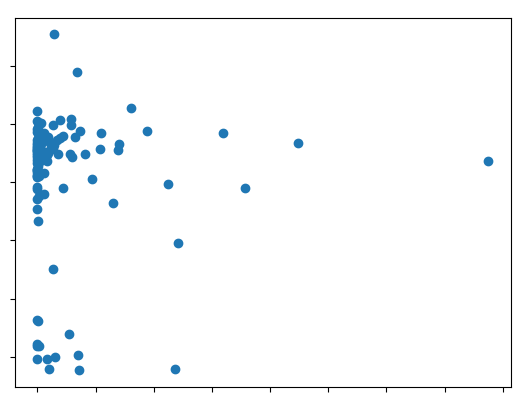

In [22]:
# 강수량과 target의 관계 시각화
plt.scatter(merged_df['강수량(mm)'], merged_df['target'])
plt.xlabel('강수량(mm)')
plt.ylabel('target')
plt.title('강수량과 target의 관계')
plt.show()

### 지도 시각화
- 아직 못함

In [30]:
import folium
from folium.plugins import HeatMap

# 지도 중심 위치 설정
center_lat = train['start_latitude'].mean()
center_lon = train['start_longitude'].mean()

# Folium 지도 객체 생성
m = folium.Map(location=[center_lat, center_lon], zoom_start=10)

# 도로 데이터를 순회하며 지도에 표시
for index, row in train.iterrows():
    start_lat = row['start_latitude']
    start_lon = row['start_longitude']
    end_lat = row['end_latitude']
    end_lon = row['end_longitude']
    target = row['target']
    
    # 시작점과 끝점을 선으로 연결
    folium.PolyLine(locations=[(start_lat, start_lon), (end_lat, end_lon)], color='blue').add_to(m)
    
    # 시작점과 끝점을 원으로 표시
    folium.CircleMarker(location=(start_lat, start_lon), radius=5, color='green', fill=True, fill_color='green').add_to(m)
    folium.CircleMarker(location=(end_lat, end_lon), radius=5, color='red', fill=True, fill_color='red').add_to(m)
    
    # 도로의 target을 색으로 표현
    heat_data = [[start_lat, start_lon, target], [end_lat, end_lon, target]]
    HeatMap(heat_data).add_to(m)



In [88]:
from sklearn.preprocessing import LabelEncoder

items =  ['day_of_week', 'road_name', 'start_node_name', 'start_turn_restricted', 'end_node_name', 'end_turn_restricted','is_holiday']
train_label = train.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(train_label[i])
    train_label[i] = encoder.transform(train_label[i])
train_label = train_label.drop('id', axis=1)

KeyError: 'is_holiday'

In [102]:
train_label[train_label['vehicle_restricted'] != 0]

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,...,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day,is_holiday


In [104]:
train_label = train_label.drop('vehicle_restricted', axis=1)
train_label.head()

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,weight_restricted,...,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,datetime,year,month,day,is_holiday
0,20220623,1,17,1,106,46,0,0,60.0,32400.0,...,386,33.427749,126.662335,0,52.0,2022-06-23,2022,6,23,0
1,20220728,1,21,2,103,34,0,0,60.0,0.0,...,2,33.504811,126.526240,0,30.0,2022-07-28,2022,7,28,0
2,20211010,4,7,2,103,36,0,0,80.0,0.0,...,179,33.280072,126.362147,0,61.0,2021-10-10,2021,10,10,0
3,20220311,0,13,2,107,57,0,0,50.0,0.0,...,203,33.245565,126.566228,0,20.0,2022-03-11,2022,3,11,0
4,20211005,6,8,2,103,35,0,0,80.0,0.0,...,269,33.462677,126.330152,0,38.0,2021-10-05,2021,10,5,0


- vehicle_restricted 모든값 0임

In [66]:
print(train[train['road_name'] == '-']['road_rating'].value_counts())
print(train[train['road_name'] == '-']['road_type'].value_counts())
# print(train[train['road_name'] == '-']['start_node_name'].value_counts())
train[train['road_name'] == '-']['start_latitude'].value_counts()

road_rating
107    569463
Name: count, dtype: int64
road_type
0    481943
3     87520
Name: count, dtype: int64


start_latitude
33.472276    15824
33.418412    13748
33.408431    13218
33.466433    12091
33.466607    12091
             ...  
33.288368     2493
33.246912     1425
33.248633     1417
33.305867      472
33.308236      464
Name: count, Length: 84, dtype: int64

### Label Encoding

In [5]:
from sklearn.preprocessing import LabelEncoder

items =  ['day_of_week', 'road_name', 'start_node_name', 'start_turn_restricted', 'end_node_name', 'end_turn_restricted']
train_label = train.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(train_label[i])
    train_label[i] = encoder.transform(train_label[i])

items =  ['day_of_week', 'road_name', 'start_node_name', 'start_turn_restricted', 'end_node_name', 'end_turn_restricted']
test_label = test.copy()
encoder = LabelEncoder()

for i in items:
    encoder = LabelEncoder()
    encoder.fit(test_label[i])
    test_label[i] = encoder.transform(test_label[i])

### Feature Scaling
- minmax vs standard 실험
  - 둘다 4.8대로 별 차이 없다.

In [97]:
train_label.head(2)
test_label.head(2)

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,height_restricted,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted
0,TEST_000000,20220825,1,17,3,107,27,0,0,70.0,...,0.0,0,79,33.499427,126.541298,0,208,33.500772,126.543837,1
1,TEST_000001,20220809,6,12,2,103,30,0,0,70.0,...,0.0,3,211,33.258507,126.427003,0,9,33.258119,126.415840,0


In [6]:
y_train = train_label['target'] 
X_train = train_label.drop(['id','base_date', 'target','road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)

X_test = test_label.drop(['id','base_date', 'road_name', 'start_node_name', 'end_node_name','vehicle_restricted'], axis=1)



print(X_train.shape)
print(y_train.shape)
print(test.shape)

(4701217, 16)
(4701217,)
(291241, 22)


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

scaler.fit(X_train)
X_train.loc[:, :] = scaler.transform(X_train)
X_test.loc[:, :] = scaler.transform(X_test)

X_test.head(2)

,day_of_week,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,start_turn_restricted,end_latitude,end_longitude,end_turn_restricted
0,0.166667,0.739130,1.0,1.0,0,0,0.8,0.0,0.0,0,0.818794,0.479313,0,0.823099,0.482705,1
1,1.000000,0.521739,0.5,0.0,0,0,0.8,0.0,0.0,1,0.048218,0.326579,0,0.046978,0.311660,0


### Train-Test Split

In [8]:
from sklearn.model_selection import train_test_split
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.2, 
                                            stratify=train['base_hour'], random_state=2021)

print(X_tr.shape, y_tr.shape)
print(X_val.shape, y_val.shape)

(3760973, 16) (3760973,)
(940244, 16) (940244,)


### 모델 선언 및 학습

### LGBMRegressor

In [22]:
LR = lgb.LGBMRegressor(random_state=42).fit(X_tr, y_tr,eval_set=[(X_val, y_val)])

from sklearn.metrics import mean_absolute_error

print(f"훈련 셋: {mean_absolute_error(y_tr, LR.predict(X_tr))}")
print(f"검증 셋: {mean_absolute_error(y_val, LR.predict(X_val))}")

[1]	valid_0's l2: 223.568
[2]	valid_0's l2: 197.968
[3]	valid_0's l2: 177.359
[4]	valid_0's l2: 160.475
[5]	valid_0's l2: 146.248
[6]	valid_0's l2: 134.452
[7]	valid_0's l2: 124.716
[8]	valid_0's l2: 116.483
[9]	valid_0's l2: 109.477
[10]	valid_0's l2: 103.58
[11]	valid_0's l2: 98.4871
[12]	valid_0's l2: 93.9241
[13]	valid_0's l2: 90.0366
[14]	valid_0's l2: 86.5972
[15]	valid_0's l2: 83.5819
[16]	valid_0's l2: 81.088
[17]	valid_0's l2: 78.5266
[18]	valid_0's l2: 76.4008
[19]	valid_0's l2: 74.5915
[20]	valid_0's l2: 72.5546
[21]	valid_0's l2: 71.1483
[22]	valid_0's l2: 69.8666
[23]	valid_0's l2: 68.5555
[24]	valid_0's l2: 67.141
[25]	valid_0's l2: 66.219
[26]	valid_0's l2: 65.2105
[27]	valid_0's l2: 64.397
[28]	valid_0's l2: 63.196
[29]	valid_0's l2: 62.1431
[30]	valid_0's l2: 61.4745
[31]	valid_0's l2: 60.7896
[32]	valid_0's l2: 60.1616
[33]	valid_0's l2: 59.3385
[34]	valid_0's l2: 58.8818
[35]	valid_0's l2: 58.1713
[36]	valid_0's l2: 57.2555
[37]	valid_0's l2: 56.8706
[38]	valid_0's l

In [111]:
from sklearn.model_selection import StratifiedKFold as kfold
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error

# 연속적인 값인 만큼 stratify kfold 를 사용할 수 없지만 나누는 것은 kfold와 동일합니다.
kf = kfold(n_splits = 3, shuffle = True, random_state = 42)
split = kf.split(X_train, y_train)

# 평균 mae를 확인하기 위한 리스트
mae_list1 = []
mae_list2 = []

# 폴드별 예측값 저장을 위한 리스트
test_pred_list1 = []
test_pred_list2 = []

for train, test in split:
    x_train, x_val, y_train, y_val = X_train.iloc[train], X_train.iloc[test], y_train.iloc[train], y_train.iloc[test]    

    rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=10,
                                min_samples_split=10, random_state=2022)
    et = ExtraTreesRegressor(n_estimators = 40, min_samples_split=10, min_samples_leaf = 10, random_state = 2022)

    rf.fit(x_train, y_train)
    et.fit(x_train, y_train)

    pred1 = rf.predict(x_val)
    pred2 = et.predict(x_val)

    result1 = mean_absolute_error(pred1,y_val)
    result2 = mean_absolute_error(pred2,y_val)

    mae_list1.append(result1)
    mae_list2.append(result2)

    print(f'RandomForestRegressor mae : {result1:.4f}', end='\n\n')
    print(f'ExtraTreeRegressor mae : {result2:.4f}', end='\n\n')
    
    test_pred_list1.append(rf.predict(X_test))
    test_pred_list2.append(et.predict(X_test))

print(f'mean mae {np.mean(mae_list1):.4f}')
print(f'mean mae {np.mean(mae_list2):.4f}')

KeyboardInterrupt: 

### GBM

SyntaxError: invalid syntax (3954761559.py, line 1)

### XGBoost

In [110]:
import xgboost as xgb

xgb_model = xgb.XGBRegressor(n_estimators=10000, 
                              max_depth=5, 
                              subsample=0.3,
                              colsample_bytree=0.5,
                              reg_lambda=15,
                              random_state=20)


xgb_model.fit(X_tr, y_tr,
                eval_set=[(X_val, y_val)],
                eval_metric='mae',
                verbose=100,
                early_stopping_rounds=200)    


from sklearn.metrics import mean_absolute_error
print(f"훈련 셋: {mean_absolute_error(y_tr, xgb_model.predict(X_tr))}")
print(f"검증 셋: {mean_absolute_error(y_val, xgb_model.predict(X_val))}")

[0]	validation_0-mae:29.67114
[100]	validation_0-mae:4.45252
[200]	validation_0-mae:4.03766
[300]	validation_0-mae:3.90533
[400]	validation_0-mae:3.83617
[500]	validation_0-mae:3.79094
[600]	validation_0-mae:3.75921
[700]	validation_0-mae:3.73539
[800]	validation_0-mae:3.71908
[900]	validation_0-mae:3.70466
[1000]	validation_0-mae:3.69649
[1100]	validation_0-mae:3.68757
[1200]	validation_0-mae:3.67691
[1300]	validation_0-mae:3.66922
[1400]	validation_0-mae:3.66366
[1500]	validation_0-mae:3.65949
[1600]	validation_0-mae:3.65574
[1700]	validation_0-mae:3.65130
[1800]	validation_0-mae:3.64790
[1900]	validation_0-mae:3.64439
[2000]	validation_0-mae:3.64124
[2100]	validation_0-mae:3.63892
[2200]	validation_0-mae:3.63705
[2300]	validation_0-mae:3.63420
[2400]	validation_0-mae:3.63180
[2500]	validation_0-mae:3.62968
[2600]	validation_0-mae:3.62688
[2700]	validation_0-mae:3.62516
[2800]	validation_0-mae:3.62281
[2900]	validation_0-mae:3.62025
[3000]	validation_0-mae:3.61896
[3100]	validation_0

KeyboardInterrupt: 

### 추론

In [10]:
pred = LR.predict(test)

### Submission

In [12]:
sample_submission = pd.read_csv('./data/sample_submission.csv')

In [13]:
sample_submission['target'] = pred
sample_submission.to_csv("./data/submit.csv", index = False)

In [14]:
sample_submission

,id,target
0,TEST_000000,27.298710
1,TEST_000001,43.949243
2,TEST_000002,60.552621
3,TEST_000003,36.499322
4,TEST_000004,37.510570
...,...,...
291236,TEST_291236,45.902276
291237,TEST_291237,52.604831
291238,TEST_291238,21.964371
291239,TEST_291239,25.402628
